# Calculating indices for quantitative analysis

In this lesson, we'll:

* Learn how to calculate indices from Landsat scenes using xlandsat
* Visualize the indices with pseudo-color maps
* Derive quantitative information about out data from the indices

## Importing

We'll start by importing the usual libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xlandsat as xls

## Data

We'll two different scenes for this lesson from before and after the [Brumadinho tailings dam disaster](https://en.wikipedia.org/wiki/Brumadinho_dam_disaster) that happened in 2019 in Brazil.

Do the following to download the data:

1. Brumadinho: Download the cropped scenes from https://doi.org/10.6084/m9.figshare.21665630.v2. The files are `LC08_L2SP_218074_20190114_20200829_02_T1-cropped.tar.gz` and `LC08_L2SP_218074_20190130_20200829_02_T1-cropped.tar.gz`
1. Drag and drop it into the file browser on JupyterLab to make sure it's in the same folder as this notebook

Once we have the files in the same folder as this notebook, we can load the scenes into an `xarray.Dataset` using xlandsat. 

In [2]:
brumadinho_before = xls.load_scene("LC08_L2SP_218074_20190114_20200829_02_T1-cropped.tar.gz")
brumadinho_after = xls.load_scene("LC08_L2SP_218074_20190130_20200829_02_T1-cropped.tar.gz")
brumadinho_after

<xarray.Dataset>
Dimensions:   (easting: 400, northing: 300)
Coordinates:
  * easting   (easting) float64 5.844e+05 5.844e+05 ... 5.963e+05 5.964e+05
  * northing  (northing) float64 -2.232e+06 -2.232e+06 ... -2.223e+06 -2.223e+06
Data variables:
    blue      (northing, easting) float16 0.0686 0.07043 ... 0.05823 0.0564
    green     (northing, easting) float16 0.1027 0.09839 ... 0.07593 0.07043
    red       (northing, easting) float16 0.09778 0.09778 ... 0.06799 0.06177
    nir       (northing, easting) float16 0.2988 0.2715 0.2881 ... 0.2637 0.251
    swir1     (northing, easting) float16 0.2311 0.2274 0.2316 ... 0.1608 0.142
    swir2     (northing, easting) float16 0.145 0.1442 0.144 ... 0.09961 0.08655
Attributes: (12/19)
    Conventions:                CF-1.8
    title:                      Landsat 8 scene from 2019-01-30 (path/row=218...
    digital_object_identifier:  https://doi.org/10.5066/P9OGBGM6
    origin:                     Image courtesy of the U.S. Geological Survey
    landsat_product_id:         LC08_L2SP_218074_20190130_20200829_02_T1
    processing_level:           L2SP
    ...                         ...
    ellipsoid:                  WGS84
    date_acquired:              2019-01-30
    scene_center_time:          12:57:09.1851220Z
    wrs_path:                   218
    wrs_row:                    74
    mtl_file:                   GROUP = LANDSAT_METADATA_FILE\n  GROUP = PROD...

---

### 🤔 **Your turn** 

Make RGB (true color) composites of the before and after scenes and plot them. This is crucial so we know what we're dealing with before going for calculations and analysis.

> 💡 **Tip:** Use [`xlandsat.composite`](https://www.compgeolab.org/xlandsat/latest/api/generated/xlandsat.composite.html#xlandsat.composite).

---

## Quantify vegetation with the NDVI

When the Brumadinho tailings dam collapsed, it flooded a huge region with toxic mining waste and mud. The region that was flooded was relatively vegetated with farms and some small woods (as can be seed from the RGB plots). So if we want to quantify how large of an area was flooded with mud, we can try to determine how much vegetated area was lost.

The Normalized Difference Vegetation Index (NDVI) was designed to highlight the spectral signature of chlorophyll: weak reflectance on red and strong reflectance on near-infrared. The index is basically the difference between these two bands:

$$ NDVI = \dfrac{NIR - RED}{NIR + RED} $$

If vegetation is present in a given pixel, the NDVI will be close to 1. Smaller or negative NDVI generally means less vegetation (or less healthy vegetation). **Beware that none of these indices are absolute truths!** 

With xarray, it's very straight forward to calculate the NDVI.

In [3]:
ndvi_before = (brumadinho_before.nir - brumadinho_before.red) / (brumadinho_before.nir + brumadinho_before.red)
ndvi_before

<xarray.DataArray (northing: 300, easting: 400)>
array([[0.4604, 0.4507, 0.5728, ..., 0.545 , 0.594 , 0.554 ],
       [0.445 , 0.478 , 0.479 , ..., 0.628 , 0.5664, 0.4626],
       [0.4734, 0.494 , 0.4739, ..., 0.6387, 0.596 , 0.588 ],
       ...,
       [0.5044, 0.5186, 0.4983, ..., 0.527 , 0.4824, 0.474 ],
       [0.4883, 0.47  , 0.4724, ..., 0.525 , 0.476 , 0.4553],
       [0.5024, 0.476 , 0.4934, ..., 0.479 , 0.4536, 0.458 ]],
      dtype=float16)
Coordinates:
  * easting   (easting) float64 5.835e+05 5.835e+05 ... 5.954e+05 5.955e+05
  * northing  (northing) float64 -2.232e+06 -2.232e+06 ... -2.223e+06 -2.223e+06

That's it! The magic of xarray takes care of performing the operations on a pixel-by-pixel basis and giving us back another array with coordinates associated.

We can plot this NDVI in the same that we plot individual bands: with a **pseudo-color map**. It's pseudo-color because the colors in it are not *real* colors, but are there to represent a given value of the data and are takes from *colormaps*. This is not to be confused with a *false color composite*, where the colors are coming from a combination of the reflectance on 3 different bands. 

> 💡 **Tip:** [This matplotlib tutorial](https://matplotlib.org/stable/tutorials/colors/colormaps.html) explains how to choose a colormap and shows all of the ones available for you to use.

Let's make a pseudo-color plot using `pcolormesh` of the NDVI using the colormap `viridis`.

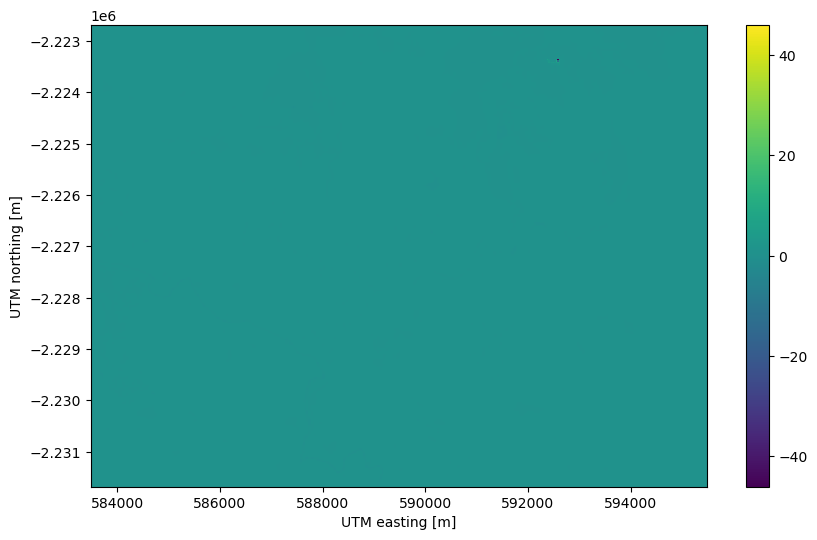

In [4]:
plt.figure(figsize=(10, 6))
ax = plt.axes()
ndvi_before.plot.pcolormesh(ax=ax, cmap="viridis")
ax.set_aspect("equal")

Well, that's disappointing. There's almost nothing in there except for one or two very low NDVI values at the top right. Let's look at the histogram of NDVI values to see what the distribution is like.

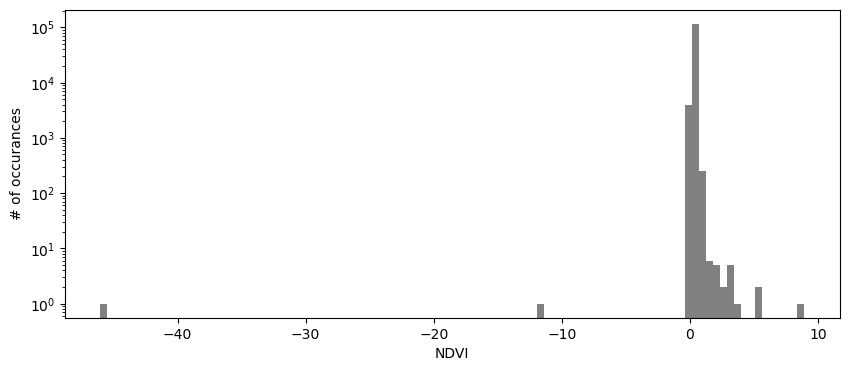

In [5]:
plt.figure(figsize=(10, 4))
ax = plt.axes()
ax.hist(ndvi_before.values.ravel(), bins=100, color="gray")
ax.set_xlabel("NDVI")
ax.set_ylabel("# of occurances")
ax.set_yscale("log")

Well, looks like most of our values are close to 0 except for a few outliers. So we need to limit the range of values in our color mapping in order to actually see the differences between those values. We can do this by passing the `vmin` and `vmax` values to `pcolormesh`.

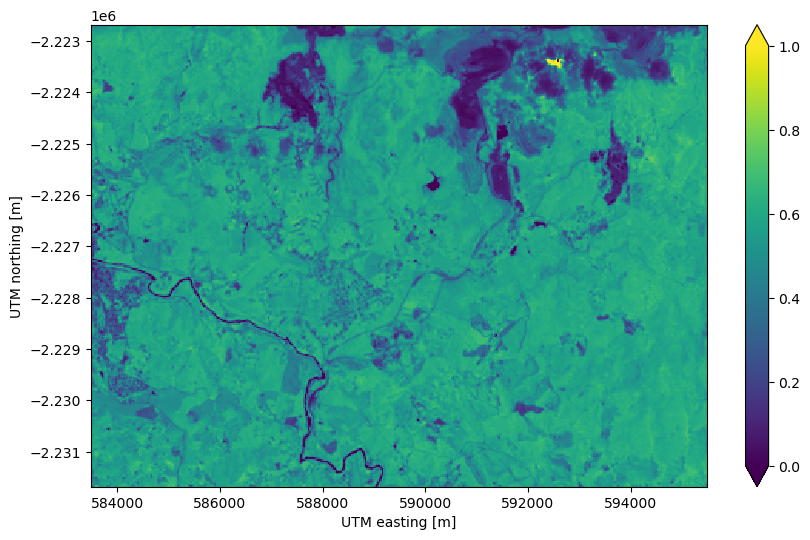

In [6]:
plt.figure(figsize=(10, 6))
ax = plt.axes()
ndvi_before.plot.pcolormesh(ax=ax, cmap="viridis", vmin=0, vmax=1)
ax.set_aspect("equal")

Alright, now we can see the rivers, fields and woods, clouds in the northwest (which were causing the extreme NDVI values). The tailings dam a small lake at the end of the river crossing to SE-NW.

---

### 🤔 **Your turn** 

Calculate and plot the NDVI for the after scene. What do you see? Can you spot the effect of the dam collapse?

> 💡 **Tip:** When comparing two pseudo-color plot, it's often a good idea to make sure the range of values (`vmin` and `vmax`) and the colormap for both of them match. That way the colors can be compared directly.

----

## Calculating areas

One way to answer out question about how much area was flooded is to:

1. Calculate the total area with vegetation around the center of the image before and after the disaster.
1. Subtract the two values.

We can calculate areas from these images by counting the number of pixels that obey a certain criteria (for example, NDVI > 0.5). Since we know that these pixels from Landsat 8 are 30m x 30m in area, the total area will be the number of pixels times the area of a pixel.

**Before we can do this**, we need to make sure that the region we're comparing is **exactly the same for each scene**. In other words, their East, West, South, North bounding box must be exactly the same. 

If you pay close to attention to the images we generated above, you'll see that the area of these two scenes is not the same. So we need to **crop** them before we can proceed. Once again, xarray makes the cropping process very convenient. We need to use `.sel` method of our scenes and NDVIs.

> 💡 **Tip:** This [xarray tutorial on indexing and selecting data](https://docs.xarray.dev/en/stable/user-guide/indexing.html) explains how it works and the many options available.

Here, I'll take my min/max easting and northing values by looking at the images and guessing based on the axis labels. The cropping will also help us get rid of the clouds in the North that would surely bias our calculations.

In [7]:
ndvi_before_crop = ndvi_before.sel(easting=slice(587000, 593000), northing=slice(-2230000, -2225000))
ndvi_before_crop

<xarray.DataArray (northing: 167, easting: 200)>
array([[0.551 , 0.536 , 0.4941, ..., 0.608 , 0.6035, 0.622 ],
       [0.4944, 0.5063, 0.503 , ..., 0.616 , 0.609 , 0.5845],
       [0.4963, 0.5054, 0.5063, ..., 0.617 , 0.616 , 0.5176],
       ...,
       [0.596 , 0.6113, 0.6084, ..., 0.55  , 0.5444, 0.5654],
       [0.5957, 0.6177, 0.62  , ..., 0.568 , 0.5693, 0.5386],
       [0.6104, 0.613 , 0.611 , ..., 0.5625, 0.543 , 0.4978]],
      dtype=float16)
Coordinates:
  * easting   (easting) float64 5.87e+05 5.87e+05 ... 5.93e+05 5.93e+05
  * northing  (northing) float64 -2.23e+06 -2.23e+06 ... -2.225e+06 -2.225e+06

> 💡 **Tip:** The exact same cropping method can be applied to the full scene and composites, not only to indices.

The cropped NDVI has the same structure as the full one and we can do the same calculations on it as we did before. Let's plot to see if the region chose was good.

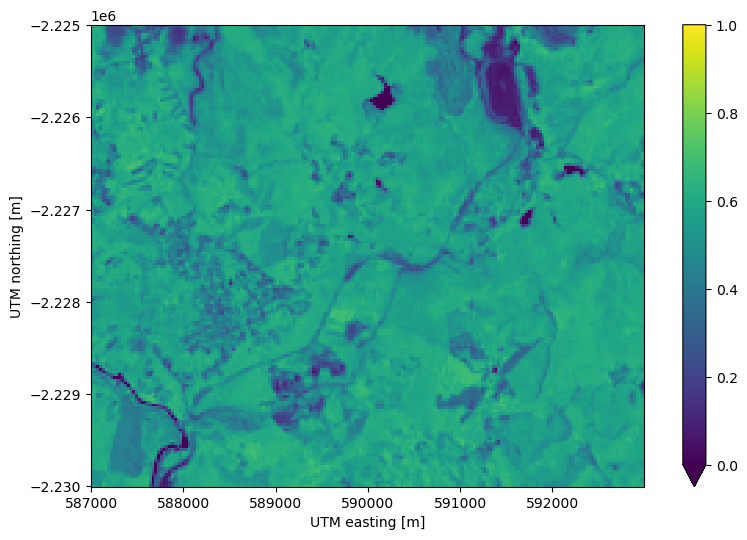

In [8]:
plt.figure(figsize=(10, 6))
ax = plt.axes()
ndvi_before_crop.plot.pcolormesh(ax=ax, cmap="viridis", vmin=0, vmax=1)
ax.set_aspect("equal")

The tailings dam is at the top right corner of this image so that's a good sign!

---

### 🤔 **Your turn** 

Crop the after NDVI and plot it as well. Do the areas of both the before and after scenes match now? Can you see the flooded region more clearly?

---

Now let's count the pixels with NDVI > 0.5, which we'll assume to be areas with vegetation. To do so, we can use the `>` operator to flag which pixels are above or below the target value.

In [9]:
is_veg_before = ndvi_before_crop > 0.5
is_veg_before

<xarray.DataArray (northing: 167, easting: 200)>
array([[ True,  True, False, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True, False]])
Coordinates:
  * easting   (easting) float64 5.87e+05 5.87e+05 ... 5.93e+05 5.93e+05
  * northing  (northing) float64 -2.23e+06 -2.23e+06 ... -2.225e+06 -2.225e+06

One neat trick we can take advantage of is the fact that *boolean values* (`True` and `False`) actually correspond to numbers: `True` is `1` and `False` is `0`. We can see this is we try to plot `is_veg_before`.

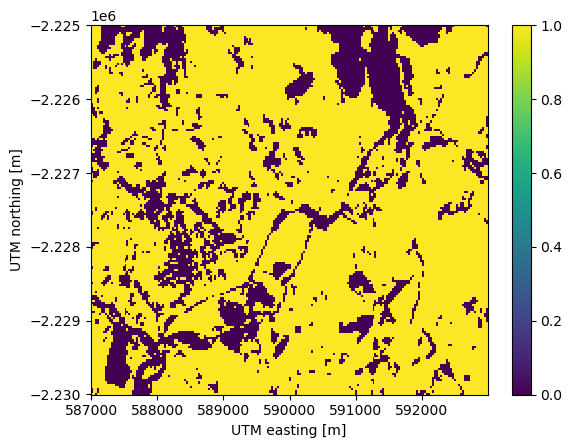

In [10]:
is_veg_before.plot()

So if we sum all of the values in `is_veg_before` it will give us the number of pixels that are `True` (NDVI > 0.5).

In [11]:
n_veg_pixels = np.sum(is_veg_before.values)
n_veg_pixels

25835

And finally, we can multiply this by 30² m² to get the area of the before scene.

In [12]:
veg_area_before = n_veg_pixels * 30**2
print(veg_area_before, "m²")

23251500 m²


Now all we have to do is repeat this for the after scene and we can figure out the area that was affected by the flood.

---

### 🤔 **Your turn** 

1. Figure out the area that was affected by the flood. 
1. For context, figure out how many football pitches correspond to this area.
1. Is NDVI > 0.5 a good cutoff value? What is it meant to do? Is it good at doing that?
1. Redo the calculations with a different NDVI cutoff value and see if your results change.
1. What should you keep in mind when communicating these results?